In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load Data

In [2]:
# Load Data
#df = pd.read_csv('LEOSS Kuehn 08 25/SUF_Kuehn_200825.csv', sep=';')
df = pd.read_csv('LEOSS_Kuehn_2020_10_14/SUF_Kuehn_201014.csv', sep=';')

# Only keep entries that either recovered or died specifically from Covid-19
df = df[np.any([(df['BL_LastKnownStatus'] == 2).values, (df['BL_LastKnownStatus'] == 3).values], axis=0)]
print(df.columns)
display(df['BL_Duration_InpatientstayNewCat'])
# Discard entries with unknown age and convert to int
df = df[df['BL_Age']!='*']
df['BL_Age'] = df['BL_Age'].astype(int)


Index(['BL_Age', 'BL_Gender', 'BL_Ethnicity', 'BL_Residence',
       'BL_CountryDiagnosis', 'BL_AdmissionComputedNewCat', 'BL_Outpatient',
       'BL_TestingOutpatient', 'BL_Transport', 'BL_Transport_Other_bit',
       'BL_Resident', 'BL_Resident_Other_bit', 'BL_Discharge',
       'BL_Discharge_Oher_bit', 'BL_EmergencyAdmission',
       'BL_MonthFirstDiagnosis', 'BL_DaysInfectionContactNewCat',
       'BL_StageDiagnosis', 'BL_UCstartday_bit', 'BL_UCstartdayNewCategories',
       'BL_COstartday_bit', 'BL_COstartdayNewCategories', 'BL_CRstartday_bit',
       'BL_CRstartdayNewCategories', 'BL_REstartday_bit',
       'BL_REstartdayNewCategories', 'BL_Duration_InpatientstayNewCat',
       'BL_Inpatient', 'BL_Duration_ICUStayNewCat', 'BL_ICU',
       'BL_Duration_VentilationNewCat', 'BL_Ventilation',
       'BL_ObservationalPeriodNewCat', 'BL_LastKnownStatus', 'BL_BMI',
       'BL_Symp_Asymptomatic', 'BL_Symp_AsymptomaticUnknown',
       'UC_Symp_Asymptomatic', 'UC_Symp_AsymptomaticUnknown',

0             9
1       [50;56]
3            12
4       [50;56]
5       [44;49]
         ...   
3672          0
3673          8
3674          0
3675          0
3676          0
Name: BL_Duration_InpatientstayNewCat, Length: 3292, dtype: object

In [3]:
# Reads the values of a single column, which consits of strings. 
# The entry of the column may contain values like '<3' and '>15',
# which are replaced by min_val or max_val
def read_column(df, min_val=None, max_val=None):
    duration = []
    for i in range(len(df)):
        if ';' in df.values[i]:
            sc_ind = df.values[i].find(';')
            min_val =int(df.values[i][1:sc_ind])
            
            max_val =int(df.values[i][sc_ind+1:-1])
            duration.append(int((min_val + max_val)/2))
            
        elif '>' in df.values[i]:
            duration.append(int(df.values[i][2:])+1)
        elif '<' in df.values[i]:
            duration.append(int(df.values[i][2:])-1)
        else:
            if(int(df.values[i])>= 0):
                duration.append(int(df.values[i]))
            
    print("Number of Patients: ", len(duration))
            
    return duration

In [4]:
def save_df(ages, unique_list, count_list, name):
    min_u = 0
    max_u = -100
    for age in range(len(ages)):
        if len(unique_list[age])>0:
            min_u = min(min_u, min(unique_list[age]))
            max_u = max(max_u, max(unique_list[age]))
    print(min_u, max_u)
    cols = [str(x) for x in range(min_u, max_u + 1)]
    count_data = np.zeros((len(ages), len(cols)))
    for age in range(len(ages)):
        counter = 0
        if len(unique_list[age])>0:
            for i in range(len(cols)):
                if int(cols[i]) == unique_list[age][counter]:
                    count_data[age, i] = count_list[age][counter]
                    if counter < len(unique_list[age])-1:
                        counter += 1
                
    count_df = pd.DataFrame(count_data, columns=cols, index=ages)
    display(count_df)
    count_df.to_csv(name + '.csv')

In [5]:
# Calculates probabilities of ICU transfer during hospital stay (mu_HU)
# and dying during ICU (mu_UD)

def calc_prob(df_age_groups, ages):
    mu_HU_list = []
    mu_UD_list = []
    for (df_age, age) in zip(df_age_groups, ages):
        df_hosp = df_age[['BL_Duration_InpatientstayNewCat', 'BL_Duration_ICUStayNewCat',
                          'BL_LastKnownStatus', 'BL_AdmissionComputedNewCat',
                          'BL_ICU', 'BL_Inpatient']]
        df_hosp = df_hosp[df_hosp['BL_Inpatient']=='1']
        df_icu = df_hosp[df_hosp['BL_ICU']=='1']
        df_dead = df_icu[df_icu['BL_LastKnownStatus']==3]
        df_icu_rec = df_icu[df_icu['BL_LastKnownStatus']==2]
        df_hosp_rec = df_hosp[np.all([df_hosp['BL_LastKnownStatus']==2,
                                      df_hosp['BL_ICU']!='1']
                                     , axis=0)]


        num_hosp = len(df_hosp.values[:,0])
        num_icu = len(df_icu.values[:,0])
        num_dead = len(df_dead.values[:,0])

        num_rec_hosp = len(df_hosp_rec.values[:,0])
        num_rec_icu = len(df_icu_rec.values[:,0])

        if num_hosp > 0:
            mu_HU = num_icu/num_hosp
            mu_HU_list.append(mu_HU)
        else: 
            mu_HU = 'No Entries for this Age Group'
            mu_HU_list.append(0)

        if num_icu > 0:
            mu_UD = num_dead/num_icu
            mu_UD_list.append(mu_UD)
        else:
            mu_UD = 'No Entries for this Age Group'
            mu_UD_list.append(0)

        print('Parameters for Ages', age+ ':')
        print('Theta:', mu_HU)
        print('Delta:', mu_UD)
        print('')


    if len(mu_UD_list) > 1:
        fig, ax = plt.subplots(1,1,figsize=(9,6))
        ax.plot(range(len(ages)), mu_UD_list)
        ax.set_xticks(range(len(ages)))
        ax.set_xticklabels(ages)
        ax.set_title('Probability of death during ICU',fontsize=18)
        ax.set_xlabel('Age Group', fontsize=18)
        ax.set_ylabel('Probability', fontsize=18)
        plt.show()

        fig, ax = plt.subplots(1,1,figsize=(9,6))
        ax.plot(range(len(ages)), mu_HU_list)
        ax.set_xticks(range(len(ages)))
        ax.set_xticklabels(ages)
        ax.set_title('Probability of ICU during Hospitalstay',fontsize=18)
        ax.set_xlabel('Age Group', fontsize=18)
        ax.set_ylabel('Probability', fontsize=18)
        plt.show()
    return mu_HU_list, mu_UD_list

In [6]:
# calculates average time spent in hospital before recovering
def calc_time_hosp_rec(df_age_groups, ages):
    print('R5:')
    count_list = []
    unique_list = []
    durations = []
    mean = []
    std = []
    for df_age, age in zip(df_age_groups, ages):
        print('Parameters for Ages', age+ ':')
        df_hosp_rec_dur = df_age['BL_Duration_InpatientstayNewCat'][np.all([df_age['BL_Inpatient']=='1',
                                                                       df_age['BL_LastKnownStatus']==2, 
                                                                       df_age['BL_ICU']!='1'], axis=0)]

        
        duration = read_column(df_hosp_rec_dur, 2, 15)

        print('Mean of R5:', np.mean(duration))
        print('STD of R5:', np.std(duration), '\n')
        durations.append(duration)
        mean.append(np.mean(duration))
        std.append(np.std(duration))

    fig, ax = plt.subplots(1,1,figsize=(9,6))
    
    for age in range(len(durations)):
        unique, counts = np.unique(durations[age], return_counts=True)
        count_list.append(counts)
        unique_list.append(unique)
        ax.plot(unique, counts)
                
    if len(durations) > 1:
        ax.legend(ages, fontsize=min(18,18*6/len(durations)))
    ax.set_ylim(0)
    ax.set_title('Time spent in hospital before recovering', fontsize = 18)
    ax.set_xlabel('Time [Days]', fontsize=18)
    ax.set_ylabel('Number of Patients', fontsize=18)
    plt.show()
    
    save_df(ages, unique_list, count_list, 'hosp_to_rec_age' + str(len(ages)))
    
    return mean, std

In [7]:
# calculates average time of positive test before hospital admission 
def calc_time_inf_hosp(df_age_groups, ages):
    print('R6:')
    count_list = []
    unique_list = []
    durations = []
    mean = []
    std = []
    for df_age, age in zip(df_age_groups, ages):
        print('Parameters for Ages', age+ ':')
        df_admission = df_age['BL_AdmissionComputedNewCat'][df_age['BL_AdmissionComputedNewCat']!='Missing']


        duration = read_column(df_admission, max_val=7)

        print('Mean of R6:', np.mean(duration))
        print('STD of R6:', np.std(duration))
        durations.append(duration)
        mean.append(np.mean(duration))
        std.append(np.std(duration))
        print()

    fig, ax = plt.subplots(1,1,figsize=(9,6))
    for age in range(len(durations)):
        unique, counts = np.unique(durations[age], return_counts=True)
        count_list.append(counts)
        unique_list.append(unique)
        ax.plot(unique, counts)
    if len(durations) > 1:
        ax.legend(ages, fontsize=min(18,18*6/len(durations)))
    ax.set_ylim(0)
    ax.set_title('Time of known infection before admission', fontsize = 18)
    ax.set_xlabel('Time [Days]', fontsize=18)
    ax.set_ylabel('Number of Patients', fontsize=18)
    plt.show()   
    
    save_df(ages, unique_list, count_list, 'inf_to_hosp' + str(len(ages)))

    
    return mean, std


In [8]:
# calculates average time of hospital stay before ICU admission
def calc_time_hosp_ICU(df_age_groups, ages):
    print('R7:')
    count_list = []
    unique_list = []
    durations = []
    mean = []
    std = []
    for df_age, age in zip(df_age_groups, ages):
        print('Parameters for Ages', age+ ':')
        df_hosp_icu_dead_dur = df_age[['BL_Duration_InpatientstayNewCat', 
                              'BL_Duration_ICUStayNewCat']][np.all([df_age['BL_Inpatient']=='1',
                                                              df_age['BL_LastKnownStatus']==3, 
                                                              df_age['BL_ICU']=='1'], axis=0)]
        hosp_duration = read_column(df_hosp_icu_dead_dur['BL_Duration_InpatientstayNewCat'], 2, 16)
        icu_duration = read_column(df_hosp_icu_dead_dur['BL_Duration_ICUStayNewCat'], 2, 15)

        durations.append(np.array(hosp_duration) - np.array(icu_duration))

        icu_mean = np.mean(np.array(hosp_duration) - np.array(icu_duration))
        print('Mean of R7:', np.mean(np.array(hosp_duration) - np.array(icu_duration)))
        print('STD of R7:', np.std(np.array(hosp_duration) - np.array(icu_duration)))
        mean.append(np.mean(np.array(hosp_duration) - np.array(icu_duration)))
        std.append(np.std(np.array(hosp_duration) - np.array(icu_duration)))
        print()

    fig, ax = plt.subplots(1,1,figsize=(9,6))
    for age in range(len(durations)):
        unique, counts = np.unique(durations[age], return_counts=True)
        count_list.append(counts)
        unique_list.append(unique)
        ax.plot(unique, counts)
    if len(durations) > 1:
        ax.legend(ages, fontsize=min(18,18*6/len(durations)))
    ax.set_ylim(0)
    ax.set_title('Time of Hospital Stay before ICU', fontsize = 18)
    ax.set_xlabel('Time [Days]', fontsize=18)
    ax.set_ylabel('Number of Patients', fontsize=18)
    plt.show() 
    
    save_df(ages, unique_list, count_list, 'hosp_to_icu' + str(len(ages)))
    
    return mean, std

In [9]:
# calculates average time of ICU stay before recovering
def calc_time_ICU_rec(df_age_groups, ages):
    print('R8:')
    count_list = []
    unique_list = []
    durations = []
    mean = []
    std = []
    for df_age, age in zip(df_age_groups, ages):
        print('Parameters for Ages', age+ ':')
        df_hosp_icu_dead_dur = df_age[['BL_Duration_InpatientstayNewCat', 
                              'BL_Duration_ICUStayNewCat']][np.all([df_age['BL_Inpatient']=='1',
                                                              df_age['BL_LastKnownStatus']==2, 
                                                              df_age['BL_ICU']=='1'], axis=0)]
        icu_duration = read_column(df_hosp_icu_dead_dur['BL_Duration_ICUStayNewCat'], 2, 15)

        durations.append(icu_duration)

        print('Mean of R8:', np.mean(icu_duration))
        print('STD of R8:', np.std(icu_duration))
        
        mean.append(np.mean(np.array(icu_duration)))
        std.append(np.std(np.array(icu_duration)))
        print()

    fig, ax = plt.subplots(1,1,figsize=(9,6))
    for age in range(len(durations)):
        unique, counts = np.unique(durations[age], return_counts=True)
        count_list.append(counts)
        unique_list.append(unique)
        ax.plot(unique, counts)
    if len(durations) > 1:
        ax.legend(ages, fontsize=min(18,18*6/len(durations)))
    ax.set_ylim(0)
    ax.set_title('Time of ICU Stay before Recovering', fontsize = 18)
    ax.set_xlabel('Time [Days]', fontsize=18)
    ax.set_ylabel('Number of Patients', fontsize=18)
    plt.show() 
    
    save_df(ages, unique_list, count_list, 'icu_to_rec' + str(len(ages)))
    
    return mean, std



In [10]:
# calculates average time of ICU stay before dying
def calc_time_ICU_death(df_age_groups, ages):
    print('R10:')
    count_list = []
    unique_list = []
    durations = []
    mean = []
    std = []
    for df_age, age in zip(df_age_groups, ages):
        print('Parameters for Ages', age+ ':')
        df_hosp_icu_dead_dur = df_age[['BL_Duration_InpatientstayNewCat', 
                              'BL_Duration_ICUStayNewCat']][np.all([df_age['BL_Inpatient']=='1',
                                                              df_age['BL_LastKnownStatus']==3, 
                                                              df_age['BL_ICU']=='1'], axis=0)]
        icu_duration = read_column(df_hosp_icu_dead_dur['BL_Duration_ICUStayNewCat'], 2, 15)

        durations.append(np.array(icu_duration))

        print('Mean of R10:', np.mean(icu_duration))
        print('STD of R10:', np.std(icu_duration))
        
        mean.append(np.mean(np.array(icu_duration)))
        std.append(np.std(np.array(icu_duration)))
        print()

    fig, ax = plt.subplots(1,1,figsize=(9,6))
    for age in range(len(durations)):
        unique, counts = np.unique(durations[age], return_counts=True)
        count_list.append(counts)
        unique_list.append(unique)
        ax.plot(unique, counts)
    if len(durations) > 1:
        ax.legend(ages, fontsize=min(18,18*6/len(durations)))
    ax.set_ylim(0)
    ax.set_title('Time of ICU Stay before Death', fontsize = 18)
    ax.set_xlabel('Time [Days]', fontsize=18)
    ax.set_ylabel('Number of Patients', fontsize=18)
    plt.show() 
    
    save_df(ages, unique_list, count_list, 'icu_to_death' + str(len(ages)))
    
    return mean, std

# All Ages

### Theta and Delta

In [11]:
theta, delta = calc_prob([df], ['All'])

Parameters for Ages All:
Theta: 0.28016221696519095
Delta: 0.34620024125452353



### Hospital to Recovered (R5)

R5:
Parameters for Ages All:
Number of Patients:  1918
Mean of R5: 12.145464025026069
STD of R5: 10.979277464755144 



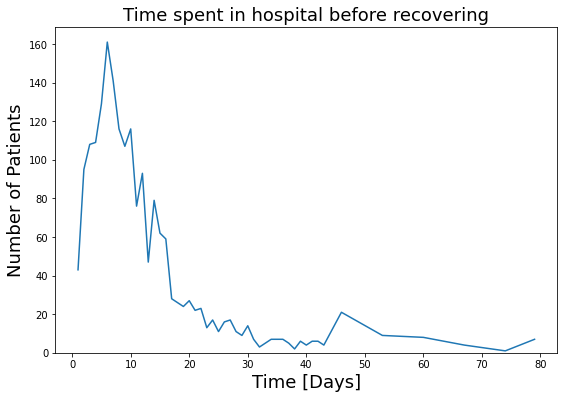

0 79


,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
All,0.0,43.0,95.0,108.0,109.0,129.0,161.0,141.0,116.0,107.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0


In [12]:
R5_mean, R5_std = calc_time_hosp_rec([df], ['All'])

### Infected to Hospital (R6)

R6:
Parameters for Ages All:
Number of Patients:  1365
Mean of R6: 7.779487179487179
STD of R6: 13.686083561541578



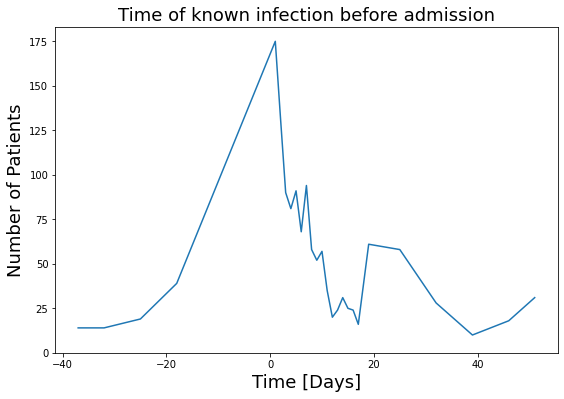

-37 51


,-37,-36,-35,-34,-33,-32,-31,-30,-29,-28,...,42,43,44,45,46,47,48,49,50,51
All,14.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,31.0


In [13]:
R6_mean, R6_std = calc_time_inf_hosp([df], ['All'])

### Hospital to ICU (R7)

R7:
Parameters for Ages All:
Number of Patients:  287
Number of Patients:  287
Mean of R7: 3.8885017421602788
STD of R7: 7.229544507304593



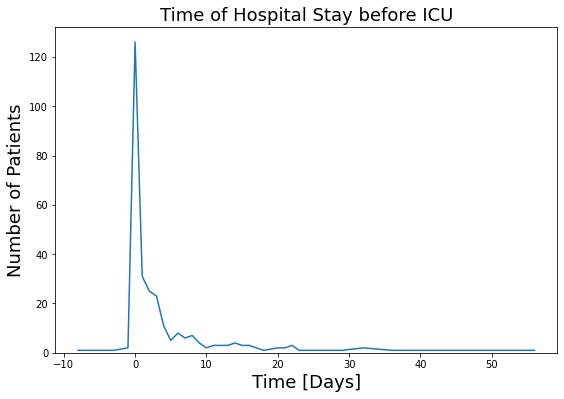

-8 56


,-8,-7,-6,-5,-4,-3,-2,-1,0,1,...,47,48,49,50,51,52,53,54,55,56
All,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,126.0,31.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [14]:
R7_mean, R7_std = calc_time_hosp_ICU([df], ['All'])

### ICU to Recovered (R8)

R8:
Parameters for Ages All:
Number of Patients:  542
Mean of R8: 17.800738007380073
STD of R8: 16.397533773299234



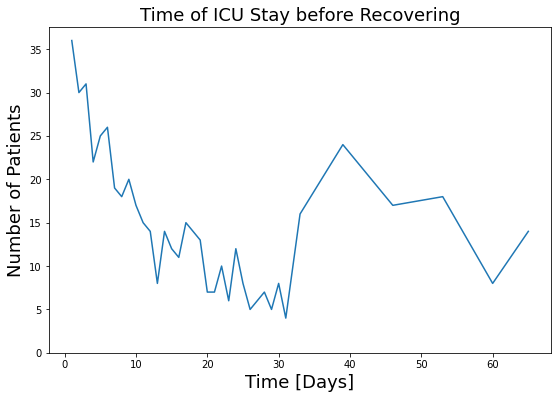

0 65


,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
All,0.0,36.0,30.0,31.0,22.0,25.0,26.0,19.0,18.0,20.0,...,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,14.0


In [15]:
R8_mean, R8_std = calc_time_ICU_rec([df], ['All'])

### ICU to Death (R10)

R10:
Parameters for Ages All:
Number of Patients:  287
Mean of R10: 15.926829268292684
STD of R10: 12.914819218699382



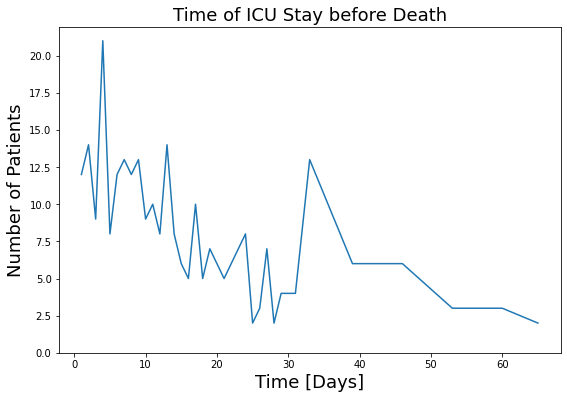

0 65


,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
All,0.0,12.0,14.0,9.0,21.0,8.0,12.0,13.0,12.0,13.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0


In [16]:
R10_mean, R10_std = calc_time_ICU_death([df], ['All'])

In [17]:
params = pd.DataFrame([theta, delta, 
                       R5_mean, R6_mean, R7_mean, R8_mean, R10_mean, 
                       R5_std, R6_std, R7_std, R8_std, R10_std], 
                      columns=['All'], index=['theta', 'delta', 
                       'R5_mean', 'R6_mean', 'R7_mean', 'R8_mean', 'R10_mean', 
                       'R5_std', 'R6_std', 'R7_std', 'R8_std', 'R10_std']).T
display(params)
params.to_csv('params_1age_groups.csv')

,theta,delta,R5_mean,R6_mean,R7_mean,R8_mean,R10_mean,R5_std,R6_std,R7_std,R8_std,R10_std
All,0.280162,0.3462,12.145464,7.779487,3.888502,17.800738,15.926829,10.979277,13.686084,7.229545,16.397534,12.914819


# 8 Age Groups

In [18]:
# Devide DF into Age Groups

df_age_groups = []
ages = ['0-4', '4-17', '15-25', '25-35', '35-45', '45-55', '55-65', '65-75', '75+']

df_age_groups.append(df[np.any([df['BL_Age']==1, df['BL_Age']==2], axis=0)]) # Age 0-4
df_age_groups.append(df[np.any([df['BL_Age']==3, df['BL_Age']==4, df['BL_Age']==5], axis=0)]) # Age 4-17
df_age_groups.append(df[np.any([df['BL_Age']==13, df['BL_Age']==14], axis=0)]) # Age 15-25
df_age_groups.append(df[df['BL_Age']==6]) # Age 25-35
df_age_groups.append(df[df['BL_Age']==7]) # Age 35-45
df_age_groups.append(df[df['BL_Age']==8]) # Age 45-55
df_age_groups.append(df[df['BL_Age']==9]) # Age 55-65
df_age_groups.append(df[df['BL_Age']==10]) # Age 65-75
df_age_groups.append(df[np.any([df['BL_Age']==11, df['BL_Age']==12], axis=0)]) # Age 75+

for df_age, age in zip(df_age_groups, ages):
    print('Number of Patients in age group', age + ':\t', len(df_age))

Number of Patients in age group 0-4:	 18
Number of Patients in age group 4-17:	 7
Number of Patients in age group 15-25:	 88
Number of Patients in age group 25-35:	 241
Number of Patients in age group 35-45:	 294
Number of Patients in age group 45-55:	 500
Number of Patients in age group 55-65:	 648
Number of Patients in age group 65-75:	 534
Number of Patients in age group 75+:	 935


### Theta and Delta

Parameters for Ages 0-4:
Theta: 0.125
Delta: 0.0

Parameters for Ages 4-17:
Theta: 0.14285714285714285
Delta: 0.0

Parameters for Ages 15-25:
Theta: 0.14516129032258066
Delta: 0.1111111111111111

Parameters for Ages 25-35:
Theta: 0.10191082802547771
Delta: 0.1875

Parameters for Ages 35-45:
Theta: 0.2248062015503876
Delta: 0.05172413793103448

Parameters for Ages 45-55:
Theta: 0.31235955056179776
Delta: 0.17985611510791366

Parameters for Ages 55-65:
Theta: 0.33613445378151263
Delta: 0.26

Parameters for Ages 65-75:
Theta: 0.37181996086105673
Delta: 0.42105263157894735

Parameters for Ages 75+:
Theta: 0.2356828193832599
Delta: 0.5747663551401869



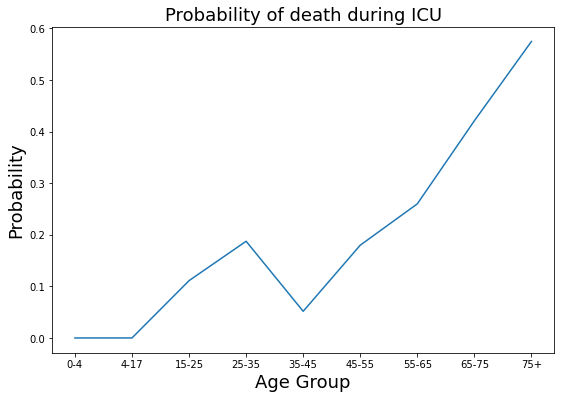

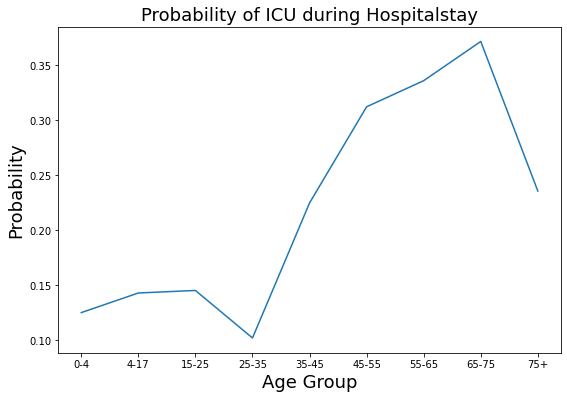

In [19]:
theta, delta = calc_prob(df_age_groups, ages)

### Hospital to Recovered (R5)

R5:
Parameters for Ages 0-4:
Number of Patients:  14
Mean of R5: 6.214285714285714
STD of R5: 5.045203824688657 

Parameters for Ages 4-17:
Number of Patients:  6
Mean of R5: 12.0
STD of R5: 18.51125783588643 

Parameters for Ages 15-25:
Number of Patients:  53
Mean of R5: 6.30188679245283
STD of R5: 5.307825855087821 

Parameters for Ages 25-35:
Number of Patients:  141
Mean of R5: 7.01418439716312
STD of R5: 5.146073095713199 

Parameters for Ages 35-45:
Number of Patients:  200
Mean of R5: 7.665
STD of R5: 5.498433867930031 

Parameters for Ages 45-55:
Number of Patients:  305
Mean of R5: 8.432786885245902
STD of R5: 5.6911988800504085 

Parameters for Ages 55-65:
Number of Patients:  393
Mean of R5: 11.04325699745547
STD of R5: 9.830660951099832 

Parameters for Ages 65-75:
Number of Patients:  300
Mean of R5: 14.3
STD of R5: 13.57853698550277 

Parameters for Ages 75+:
Number of Patients:  506
Mean of R5: 17.940711462450594
STD of R5: 12.671606346432938 



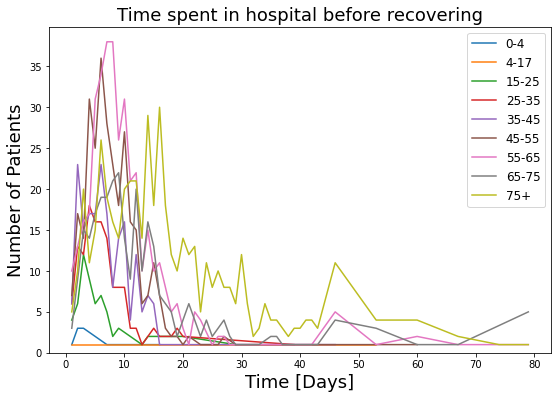

0 79


,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0-4,0.0,1.0,3.0,3.0,0.0,2.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4-17,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15-25,0.0,4.0,6.0,12.0,0.0,6.0,7.0,5.0,2.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25-35,0.0,6.0,13.0,12.0,18.0,16.0,16.0,14.0,8.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35-45,0.0,6.0,23.0,15.0,17.0,17.0,23.0,17.0,8.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45-55,0.0,7.0,17.0,14.0,31.0,25.0,36.0,28.0,23.0,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55-65,0.0,10.0,13.0,16.0,17.0,31.0,34.0,38.0,38.0,26.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
65-75,0.0,3.0,9.0,15.0,14.0,17.0,19.0,19.0,21.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
75+,0.0,5.0,10.0,20.0,11.0,15.0,26.0,19.0,16.0,14.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [20]:
R5_mean, R5_std = calc_time_hosp_rec(df_age_groups, ages)

### Infected to Hospital (R6)

R6:
Parameters for Ages 0-4:
Number of Patients:  5
Mean of R6: 17.8
STD of R6: 14.85126257258958

Parameters for Ages 4-17:
Number of Patients:  3
Mean of R6: -10.0
STD of R6: 19.200694431886227

Parameters for Ages 15-25:
Number of Patients:  45
Mean of R6: 15.577777777777778
STD of R6: 17.35958126592906

Parameters for Ages 25-35:
Number of Patients:  131
Mean of R6: 16.625954198473284
STD of R6: 16.20872250235063

Parameters for Ages 35-45:
Number of Patients:  133
Mean of R6: 9.015037593984962
STD of R6: 13.049348188951102

Parameters for Ages 45-55:
Number of Patients:  227
Mean of R6: 8.71806167400881
STD of R6: 11.091123558664071

Parameters for Ages 55-65:
Number of Patients:  288
Mean of R6: 7.277777777777778
STD of R6: 12.374337493177634

Parameters for Ages 65-75:
Number of Patients:  209
Mean of R6: 5.952153110047847
STD of R6: 12.95548534896609

Parameters for Ages 75+:
Number of Patients:  324
Mean of R6: 3.5895061728395063
STD of R6: 12.962243880702191



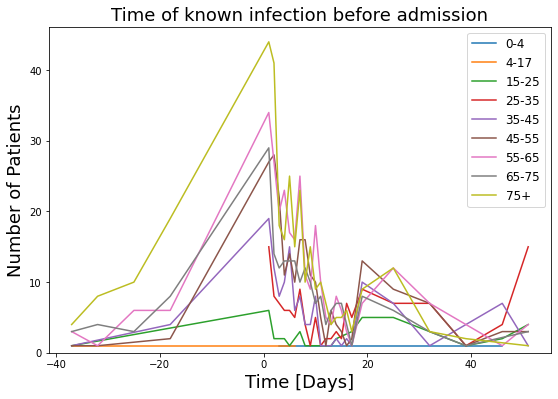

-37 51


,-37,-36,-35,-34,-33,-32,-31,-30,-29,-28,...,42,43,44,45,46,47,48,49,50,51
0-4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4-17,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15-25,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0
25-35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,15.0
35-45,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,1.0
45-55,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0
55-65,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0
65-75,3.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
75+,4.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [21]:
R6_mean, R6_std = calc_time_inf_hosp(df_age_groups, ages)

### Hospital to ICU (R7)

R7:
Parameters for Ages 0-4:
Number of Patients:  0
Number of Patients:  0
Mean of R7: nan
STD of R7: nan

Parameters for Ages 4-17:
Number of Patients:  0
Number of Patients:  0
Mean of R7: nan
STD of R7: nan

Parameters for Ages 15-25:
Number of Patients:  1
Number of Patients:  1
Mean of R7: 0.0
STD of R7: 0.0

Parameters for Ages 25-35:
Number of Patients:  3
Number of Patients:  3
Mean of R7: 1.0
STD of R7: 0.816496580927726

Parameters for Ages 35-45:
Number of Patients:  3
Number of Patients:  3
Mean of R7: 0.0
STD of R7: 0.0

Parameters for Ages 45-55:
Number of Patients:  25
Number of Patients:  25
Mean of R7: 2.24
STD of R7: 3.5584266186054756

Parameters for Ages 55-65:
Number of Patients:  52
Number of Patients:  52
Mean of R7: 3.019230769230769
STD of R7: 5.238505308751962

Parameters for Ages 65-75:


/home/wadim/Documents/envs/Leoss/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wadim/Documents/envs/Leoss/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/wadim/Documents/envs/Leoss/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/wadim/Documents/envs/Leoss/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/wadim/Documents/envs/Leoss/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/wadim/Documents/envs/Leoss/lib/python3.8/site-packages/numpy/core/fr

Number of Patients:  80
Number of Patients:  80
Mean of R7: 3.3375
STD of R7: 6.216799317172784

Parameters for Ages 75+:
Number of Patients:  123
Number of Patients:  123
Mean of R7: 5.146341463414634
STD of R7: 8.903897864655441



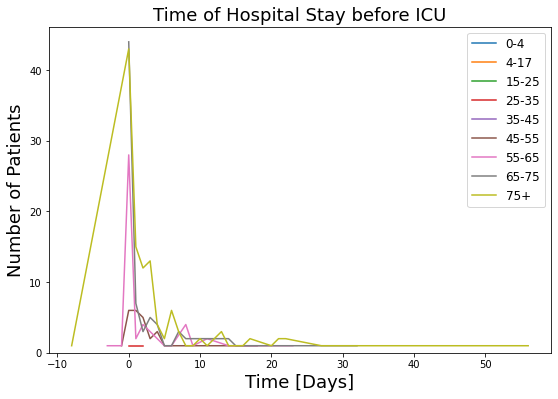

-8 56


,-8,-7,-6,-5,-4,-3,-2,-1,0,1,...,47,48,49,50,51,52,53,54,55,56
0-4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25-35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35-45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45-55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55-65,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,28.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65-75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75+,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.0,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [22]:
R7_mean, R7_std = calc_time_hosp_ICU(df_age_groups, ages)

### ICU to Recovered (R8)

R8:
Parameters for Ages 0-4:
Number of Patients:  2
Mean of R8: 7.5
STD of R8: 0.5

Parameters for Ages 4-17:
Number of Patients:  1
Mean of R8: 3.0
STD of R8: 0.0

Parameters for Ages 15-25:
Number of Patients:  8
Mean of R8: 7.375
STD of R8: 5.072905971925756

Parameters for Ages 25-35:
Number of Patients:  13
Mean of R8: 14.461538461538462
STD of R8: 17.7444049019809

Parameters for Ages 35-45:
Number of Patients:  55
Mean of R8: 15.290909090909091
STD of R8: 15.449239730953197

Parameters for Ages 45-55:
Number of Patients:  114
Mean of R8: 18.096491228070175
STD of R8: 15.941212889560001

Parameters for Ages 55-65:
Number of Patients:  148
Mean of R8: 17.777027027027028
STD of R8: 15.191934624922467

Parameters for Ages 65-75:
Number of Patients:  110
Mean of R8: 21.636363636363637
STD of R8: 18.21574108128725

Parameters for Ages 75+:
Number of Patients:  91
Mean of R8: 16.13186813186813
STD of R8: 16.576302952920663



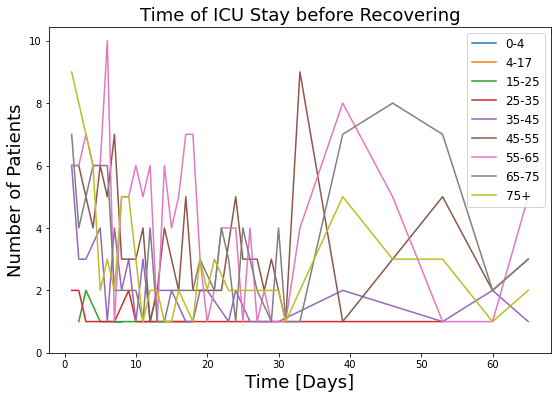

0 65


,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0-4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4-17,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15-25,0.0,0.0,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25-35,0.0,2.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35-45,0.0,6.0,3.0,3.0,0.0,4.0,1.0,4.0,2.0,3.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0
45-55,0.0,6.0,6.0,5.0,4.0,6.0,5.0,7.0,3.0,3.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0
55-65,0.0,6.0,6.0,7.0,6.0,6.0,10.0,1.0,5.0,5.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0
65-75,0.0,7.0,4.0,5.0,6.0,6.0,6.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0
75+,0.0,9.0,8.0,7.0,6.0,2.0,3.0,2.0,5.0,5.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0


In [23]:
R8_mean, R8_std = calc_time_ICU_rec(df_age_groups, ages)

### ICU to Death (R10)

R10:
Parameters for Ages 0-4:
Number of Patients:  0
Mean of R10: nan
STD of R10: nan

Parameters for Ages 4-17:
Number of Patients:  0
Mean of R10: nan
STD of R10: nan

Parameters for Ages 15-25:
Number of Patients:  1
Mean of R10: 2.0
STD of R10: 0.0

Parameters for Ages 25-35:
Number of Patients:  3
Mean of R10: 15.666666666666666
STD of R10: 5.734883511361751

Parameters for Ages 35-45:
Number of Patients:  3
Mean of R10: 11.666666666666666
STD of R10: 9.741092797468305

Parameters for Ages 45-55:
Number of Patients:  25
Mean of R10: 19.12
STD of R10: 10.14029585367212

Parameters for Ages 55-65:
Number of Patients:  52
Mean of R10: 19.5
STD of R10: 14.580677413829367

Parameters for Ages 65-75:


/home/wadim/Documents/envs/Leoss/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wadim/Documents/envs/Leoss/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/wadim/Documents/envs/Leoss/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/wadim/Documents/envs/Leoss/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/wadim/Documents/envs/Leoss/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/wadim/Documents/envs/Leoss/lib/python3.8/site-packages/numpy/core/fr

Number of Patients:  80
Mean of R10: 18.45
STD of R10: 14.078263387222162

Parameters for Ages 75+:
Number of Patients:  123
Mean of R10: 12.34959349593496
STD of R10: 10.952212339034853



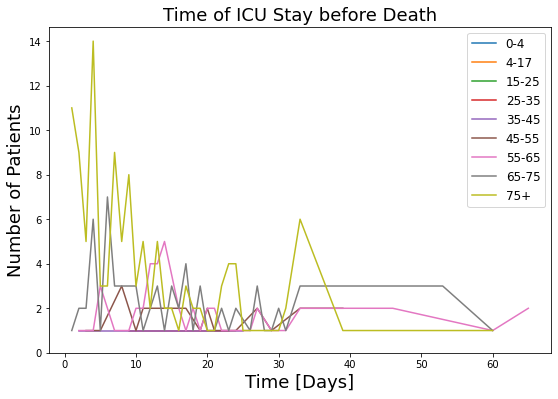

0 65


,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0-4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15-25,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25-35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35-45,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45-55,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55-65,0.0,0.0,1.0,1.0,1.0,3.0,2.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
65-75,0.0,1.0,2.0,2.0,6.0,1.0,7.0,3.0,3.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
75+,0.0,11.0,9.0,5.0,14.0,3.0,3.0,9.0,5.0,8.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [24]:
R10_mean, R10_std = calc_time_ICU_death(df_age_groups, ages)

In [25]:
params = pd.DataFrame([theta, delta, 
                       R5_mean, R6_mean, R7_mean, R8_mean, R10_mean, 
                       R5_std, R6_std, R7_std, R8_std, R10_std], 
                      columns=ages, index=['theta', 'delta', 
                       'R5_mean', 'R6_mean', 'R7_mean', 'R8_mean', 'R10_mean', 
                       'R5_std', 'R6_std', 'R7_std', 'R8_std', 'R10_std']).T
display(params)

params.to_csv('params_8age_groups.csv')

,theta,delta,R5_mean,R6_mean,R7_mean,R8_mean,R10_mean,R5_std,R6_std,R7_std,R8_std,R10_std
0-4,0.125000,0.000000,6.214286,17.800000,NaN,7.500000,NaN,5.045204,14.851263,NaN,0.500000,NaN
4-17,0.142857,0.000000,12.000000,-10.000000,NaN,3.000000,NaN,18.511258,19.200694,NaN,0.000000,NaN
15-25,0.145161,0.111111,6.301887,15.577778,0.000000,7.375000,2.000000,5.307826,17.359581,0.000000,5.072906,0.000000
25-35,0.101911,0.187500,7.014184,16.625954,1.000000,14.461538,15.666667,5.146073,16.208723,0.816497,17.744405,5.734884
35-45,0.224806,0.051724,7.665000,9.015038,0.000000,15.290909,11.666667,5.498434,13.049348,0.000000,15.449240,9.741093
45-55,0.312360,0.179856,8.432787,8.718062,2.240000,18.096491,19.120000,5.691199,11.091124,3.558427,15.941213,10.140296
55-65,0.336134,0.260000,11.043257,7.277778,3.019231,17.777027,19.500000,9.830661,12.374337,5.238505,15.191935,14.580677
65-75,0.371820,0.421053,14.300000,5.952153,3.337500,21.636364,18.450000,13.578537,12.955485,6.216799,18.215741,14.078263
75+,0.235683,0.574766,17.940711,3.589506,5.146341,16.131868,12.349593,12.671606,12.962244,8.903898,16.576303,10.952212


# 3 Age Groups

In [26]:
df_age_groups = []
ages = ['0-25', '25-55', '55+']

df_age_groups.append(df[np.any([df['BL_Age']==1, df['BL_Age']==2, 
                                df['BL_Age']==3, df['BL_Age']==4, df['BL_Age']==5, 
                                df['BL_Age']==13, df['BL_Age']==14], axis=0)]) # Age 0-25
df_age_groups.append(df[np.any([df['BL_Age']==6, df['BL_Age']==7, 
                                df['BL_Age']==8], axis=0)]) # Age 25-55
df_age_groups.append(df[np.any([df['BL_Age']==9, df['BL_Age']==10, 
                                df['BL_Age']==11, df['BL_Age']==12], axis=0)]) # Age 55+

for df_age, age in zip(df_age_groups, ages):
    print('Number of Patients in age group', age + ':\t', len(df_age))

Number of Patients in age group 0-25:	 113
Number of Patients in age group 25-55:	 1035
Number of Patients in age group 55+:	 2117


### Theta and Delta

Parameters for Ages 0-25:
Theta: 0.1411764705882353
Delta: 0.08333333333333333

Parameters for Ages 25-55:
Theta: 0.24767441860465117
Delta: 0.14553990610328638

Parameters for Ages 55+:
Theta: 0.2999006951340616
Delta: 0.42218543046357615



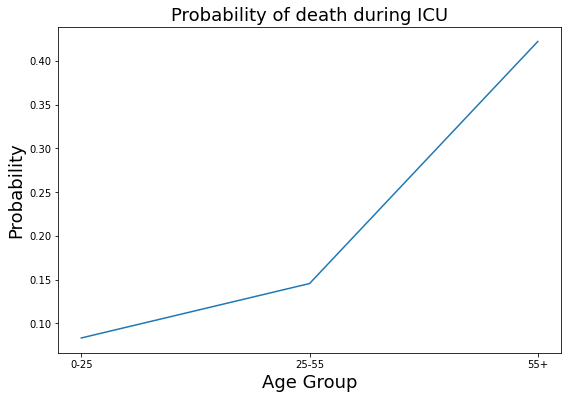

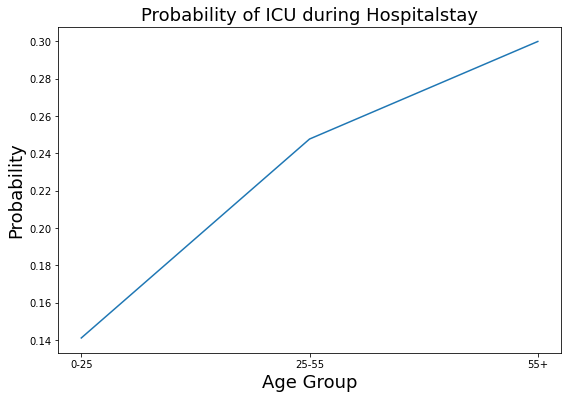

In [27]:
theta, delta = calc_prob(df_age_groups, ages)

### Hospital to Recovered (R5)

R5:
Parameters for Ages 0-25:
Number of Patients:  73
Mean of R5: 6.7534246575342465
STD of R5: 7.481082666349963 

Parameters for Ages 25-55:
Number of Patients:  646
Mean of R5: 7.885448916408668
STD of R5: 5.545690210139148 

Parameters for Ages 55+:
Number of Patients:  1199
Mean of R5: 14.768974145120934
STD of R5: 12.426699370557087 



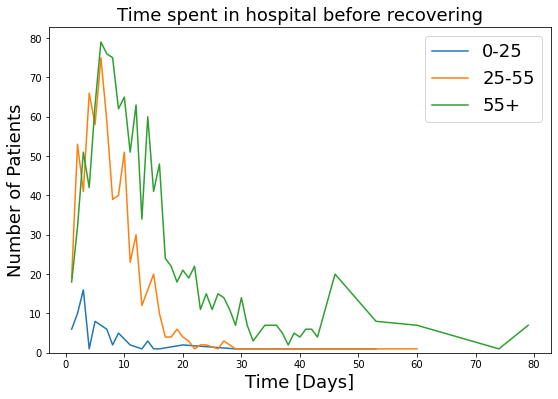

0 79


,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0-25,0.0,6.0,10.0,16.0,1.0,8.0,7.0,6.0,2.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25-55,0.0,19.0,53.0,41.0,66.0,58.0,75.0,59.0,39.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55+,0.0,18.0,32.0,51.0,42.0,63.0,79.0,76.0,75.0,62.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0


In [28]:
R5_mean, R5_std = calc_time_hosp_rec(df_age_groups, ages)

### Infected to Hospital (R6)

R6:
Parameters for Ages 0-25:
Number of Patients:  53
Mean of R6: 14.339622641509434
STD of R6: 18.262182179871278

Parameters for Ages 25-55:
Number of Patients:  491
Mean of R6: 10.908350305498981
STD of R6: 13.601610944765502

Parameters for Ages 55+:
Number of Patients:  821
Mean of R6: 5.484774665042631
STD of R6: 12.858882704702316



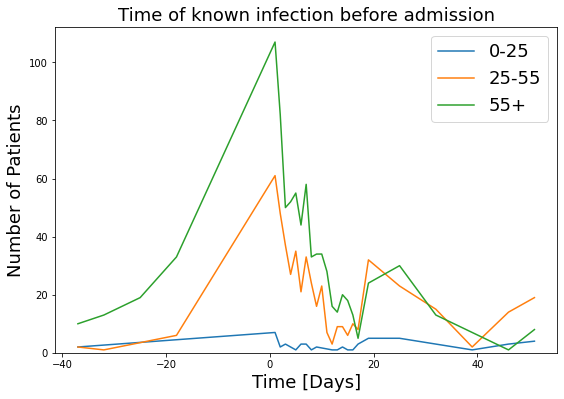

-37 51


,-37,-36,-35,-34,-33,-32,-31,-30,-29,-28,...,42,43,44,45,46,47,48,49,50,51
0-25,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0
25-55,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,19.0
55+,10.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8.0


In [29]:
R6_mean, R6_std = calc_time_inf_hosp(df_age_groups, ages)

### Hospital to ICU (R7)

R7:
Parameters for Ages 0-25:
Number of Patients:  1
Number of Patients:  1
Mean of R7: 0.0
STD of R7: 0.0

Parameters for Ages 25-55:
Number of Patients:  31
Number of Patients:  31
Mean of R7: 1.903225806451613
STD of R7: 3.2858920201927333

Parameters for Ages 55+:
Number of Patients:  255
Number of Patients:  255
Mean of R7: 4.145098039215687
STD of R7: 7.543762875629221



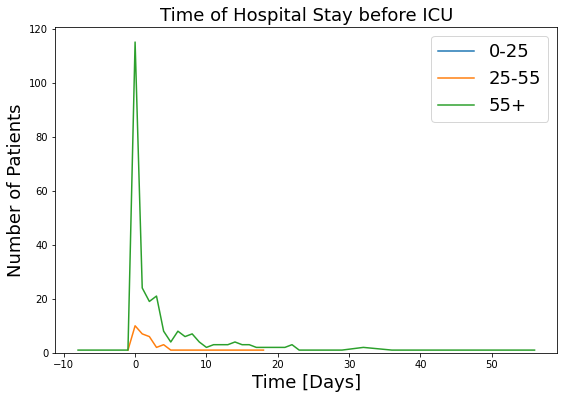

-8 56


,-8,-7,-6,-5,-4,-3,-2,-1,0,1,...,47,48,49,50,51,52,53,54,55,56
0-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25-55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55+,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,115.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [30]:
R7_mean, R7_std = calc_time_hosp_ICU(df_age_groups, ages)

### ICU to Recovered (R8)

R8:
Parameters for Ages 0-25:
Number of Patients:  11
Mean of R8: 7.0
STD of R8: 4.51260859854213

Parameters for Ages 25-55:
Number of Patients:  182
Mean of R8: 16.98901098901099
STD of R8: 15.99656179095206

Parameters for Ages 55+:
Number of Patients:  349
Mean of R8: 18.564469914040114
STD of R8: 16.69975888394938



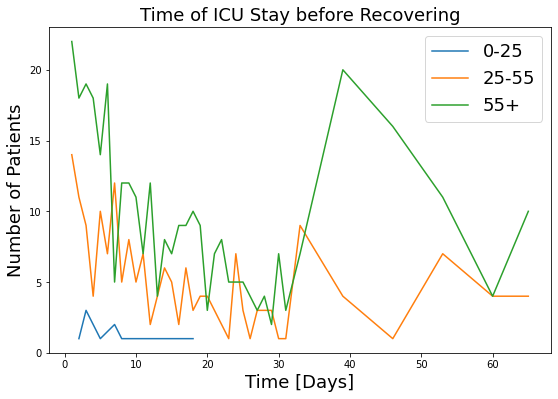

0 65


,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0-25,0.0,0.0,1.0,3.0,0.0,1.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25-55,0.0,14.0,11.0,9.0,4.0,10.0,7.0,12.0,5.0,8.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0
55+,0.0,22.0,18.0,19.0,18.0,14.0,19.0,5.0,12.0,12.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,10.0


In [31]:
R8_mean, R8_std = calc_time_ICU_rec(df_age_groups, ages)

### ICU to Death (R10)

R10:
Parameters for Ages 0-25:
Number of Patients:  1
Mean of R10: 2.0
STD of R10: 0.0

Parameters for Ages 25-55:
Number of Patients:  31
Mean of R10: 18.06451612903226
STD of R10: 10.035213753998942

Parameters for Ages 55+:
Number of Patients:  255
Mean of R10: 15.72156862745098
STD of R10: 13.195547581316227



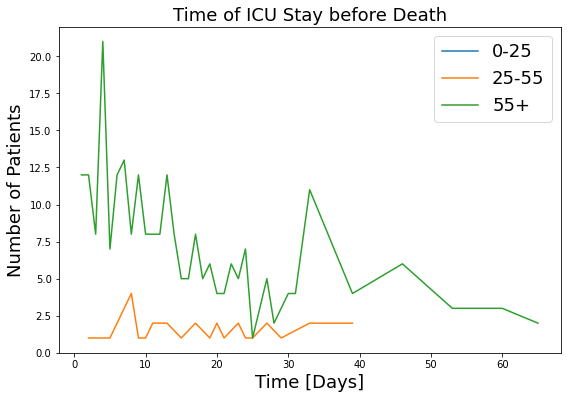

0 65


,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0-25,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25-55,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55+,0.0,12.0,12.0,8.0,21.0,7.0,12.0,13.0,8.0,12.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0


In [32]:
R10_mean, R10_std = calc_time_ICU_death(df_age_groups, ages)

In [33]:
params = pd.DataFrame([theta, delta, 
                       R5_mean, R6_mean, R7_mean, R8_mean, R10_mean, 
                       R5_std, R6_std, R7_std, R8_std, R10_std], 
                      columns=ages, index=['theta', 'delta', 
                       'R5_mean', 'R6_mean', 'R7_mean', 'R8_mean', 'R10_mean', 
                       'R5_std', 'R6_std', 'R7_std', 'R8_std', 'R10_std']).T
display(params)
params.to_csv('params_3age_groups.csv')

,theta,delta,R5_mean,R6_mean,R7_mean,R8_mean,R10_mean,R5_std,R6_std,R7_std,R8_std,R10_std
0-25,0.141176,0.083333,6.753425,14.339623,0.000000,7.000000,2.000000,7.481083,18.262182,0.000000,4.512609,0.000000
25-55,0.247674,0.145540,7.885449,10.908350,1.903226,16.989011,18.064516,5.545690,13.601611,3.285892,15.996562,10.035214
55+,0.299901,0.422185,14.768974,5.484775,4.145098,18.564470,15.721569,12.426699,12.858883,7.543763,16.699759,13.195548
